In [4]:
from entot.data.data import create_gaussians, create_gaussian_split
from entot.models.models import DiscreteOTModel, SeguyModel
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
import jax
from ott.geometry import pointcloud
from ott.problems.linear import sinkhorn, linear_problem

Here we check to what extent the conditional entropy H(Y|X) = H(X,Y)-H(X) (with H(X) constant with uniform marginals) tells something about uncertainty. Conclusion: 

# Dataset 1

In [61]:
source, target = create_gaussians(100, 100, var_source=0.2, var_target=0.2)

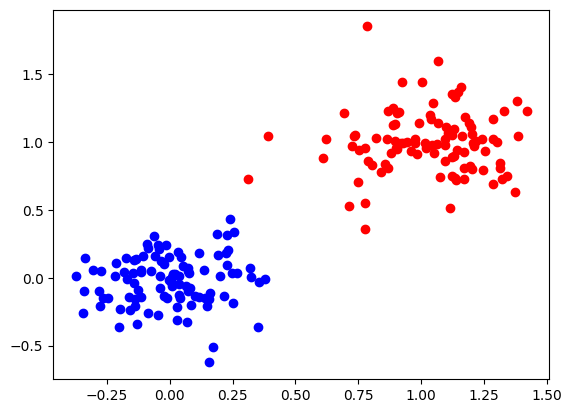

In [62]:
plt.scatter(source[:,0], source[:,1], color="blue")
plt.scatter(target[:, 0], target[:, 1], color="red")

In [63]:
def run_bootstrap(source, target, n_bootstrap=100, bootstrap_size=20, epsilon=1e-3, replace_bootstrap=True):

    collect_x = [[] for i in range(len(source))]
    collect_y = [[] for i in range(len(target))]
    rngs = [jax.random.PRNGKey(0)]

    for i in range(n_bootstrap):
        rngs = jax.random.split(rngs[-1], 5)
        x_bootstrap_ind = jax.random.choice(rngs[0], jnp.array(range(len(x))), shape=[bootstrap_size], replace=replace_bootstrap)
        y_bootstrap_ind = jax.random.choice(rngs[1], jnp.array(range(len(y))), shape=[bootstrap_size], replace=replace_bootstrap)
        x_bootstrap = x[x_bootstrap_ind]
        y_bootstrap = y[y_bootstrap_ind]
        geom = pointcloud.PointCloud(x_bootstrap, y_bootstrap, epsilon=epsilon)
        ot = sinkhorn.Sinkhorn()(linear_problem.LinearProblem(geom))
        index_source = jax.random.categorical(rngs[3], jnp.log(ot.matrix), axis=1)
        index_target = jax.random.categorical(rngs[4], jnp.log(ot.matrix), axis=0)
        for i, idx in enumerate(x_bootstrap_ind):
            collect_x[idx].append(np.asarray(y_bootstrap[index_source[i]]))
        for i, idx in enumerate(y_bootstrap_ind):
            collect_y[idx].append(np.asarray(x_bootstrap[index_target[i]]))
            
    return collect_x, collect_y

def compute_tot_variance(collect_x, collect_y):
    x_tot_var = np.array([np.sum(np.var(collect_x[i], axis=0)) for i in range(len(collect_x))])
    y_tot_var = np.array([np.sum(np.var(collect_y[i], axis=0)) for i in range(len(collect_y))])
    return x_tot_var, y_tot_var

In [ ]:
collect_x, collect_y = run_bootstrap()
x_tot_var, y_tot_var = compute_tot_variance(collect_x, collect_y)

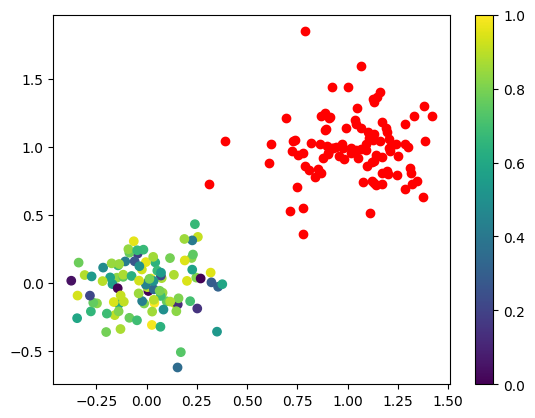

In [64]:
plt.scatter(source[:,0], source[:,1], c=x_tot_var)
p = plt.scatter(target[:, 0], target[:, 1], c=y_tot_var)
plt.colorbar(p)


# Dataset 2

In [65]:
source, target = create_gaussian_split(100, 90, var_source=0.1, var_target=0.1, seed=1)

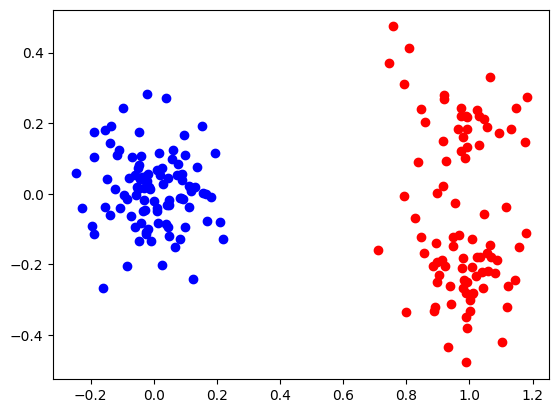

In [66]:
plt.scatter(source[:,0], source[:,1], color="blue")
plt.scatter(target[:, 0], target[:, 1], color="red")

In [67]:
collect_x, collect_y = run_bootstrap()
x_tot_var, y_tot_var = compute_tot_variance(collect_x, collect_y)

In [68]:
plt.scatter(source[:,0], source[:,1], c=x_tot_var)
p = plt.scatter(target[:, 0], target[:, 1], c=y_tot_var)
plt.colorbar(p)